In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_item, show_grasp
from dataset import ToyGraspDataset
import torch

np.random.seed(10)
torch.manual_seed(10)

Outline
1. Make datasets
2. Train Network
3. Save results

In [2]:
item = load_item('fork')

In [3]:
dataset = ToyGraspDataset(root='data', size=1200)

In [4]:
pos_ind = np.argwhere(dataset.data[:,2] == 1)
neg_ind = np.argwhere(dataset.data[:,2] == 0)

pos_ind = np.random.choice(pos_ind.squeeze(), 5)
neg_ind = np.random.choice(neg_ind.squeeze(), 5)

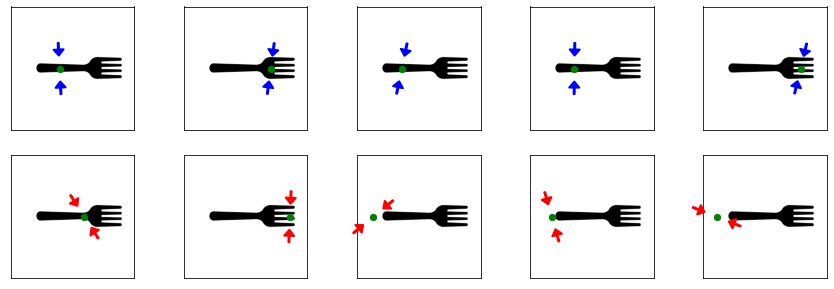

In [5]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15,5))

for i in range(5):
    ax[0][i].imshow(item, cmap='Greys')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    sample = dataset.data[pos_ind[i]]
    show_grasp(ax[0][i], sample[0], sample[1], sample[2] )
    ax[1][i].imshow(item, cmap='Greys')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    sample = dataset.data[neg_ind[i]]
    show_grasp(ax[1][i], sample[0], sample[1], sample[2] )

In [6]:
# show the data
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks
handle_masks = data[:,3] == 1
pos_combined_masks = handle_masks & pos_masks
neg_combined_masks = handle_masks & neg_masks

In [7]:
data[:,1]

array([6.158016  , 3.0941987 , 2.027204  , ..., 1.9849807 , 0.23419897,
       4.6233106 ], dtype=float32)

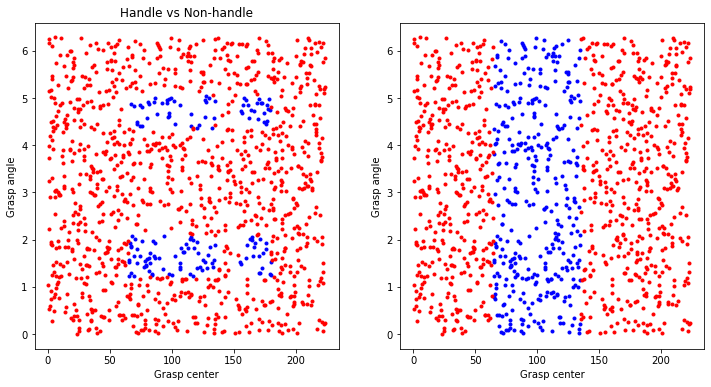

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax[0].scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax[0].set_title('Pos vs Neg')
ax[0].set_xlabel('Grasp center')
ax[0].set_ylabel('Grasp angle')

ax[1].scatter(data[handle_masks][:,0], data[handle_masks][:,1], marker='.', alpha=1.0, color='b')
ax[1].scatter(data[~handle_masks][:,0], data[~handle_masks][:,1], marker='.', alpha=1.0, color='r')
ax[0].set_title('Handle vs Non-handle')
ax[1].set_xlabel('Grasp center')
ax[1].set_ylabel('Grasp angle')
plt.show()

### Real+ vs Sim+

In [24]:
from torch.utils.data import TensorDataset, DataLoader
from network import ClassifierNN, train_network, save_model_info, load_model_info
import torch.optim as optim

torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [58]:
# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=1000, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=15, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

sim2real!!!


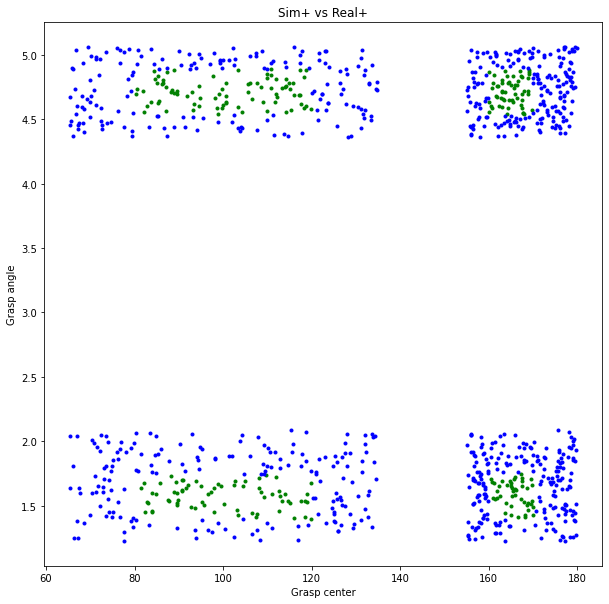

In [59]:
# np.sum(train_dataset.data[:,2])/train_dataset.data.shape[0]

# show the data
data = train_dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks



fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='g')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.set_title('Sim+ vs Real+')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

In [60]:
# first classifier balanced
f = ClassifierNN([2,32,32,1])
f = f.to(device)
optimizer = optim.Adam(f.parameters(), lr=0.001)

In [62]:
f, info = train_network(f, train_dataloader, train_dataset,
                                      test_dataloader, test_dataset,
#                                       n_epochs=400, print_freq=5, optimizer=optimizer)
                                      n_epochs=4000, print_freq=250, optimizer=optimizer)
info['pos_samples_size'] = np.sum(train_dataset.data[:,2])
info['neg_samples_size'] = train_dataset.data.shape[0] - np.sum(train_dataset.data[:,2])
save_model_info(f, info, name='sim_vs_real_1k')

Epoch: 250
Train loss: 0.0013485446572303772 | Test losses: 0.0037368320080698753
Train acc: 0.797 | Test acc: 0.7653061224489796
Epoch: 500
Train loss: 0.0013286513686180115 | Test losses: 0.0036634538246660816
Train acc: 0.785 | Test acc: 0.8112244897959183
Epoch: 750
Train loss: 0.0013202272057533265 | Test losses: 0.003632044913817425
Train acc: 0.786 | Test acc: 0.8061224489795918
Epoch: 1000
Train loss: 0.0012976780533790588 | Test losses: 0.0035943693044234296
Train acc: 0.823 | Test acc: 0.8061224489795918
Epoch: 1250
Train loss: 0.0012822388410568238 | Test losses: 0.0035688804120433573
Train acc: 0.829 | Test acc: 0.8061224489795918
Epoch: 1500
Train loss: 0.0012658305168151856 | Test losses: 0.0035379422562462942
Train acc: 0.82 | Test acc: 0.8112244897959183
Epoch: 1750
Train loss: 0.0012541258931159974 | Test losses: 0.003495582512446812
Train acc: 0.816 | Test acc: 0.8418367346938775
Epoch: 2000
Train loss: 0.0012460325956344604 | Test losses: 0.003459250440402907
Train a

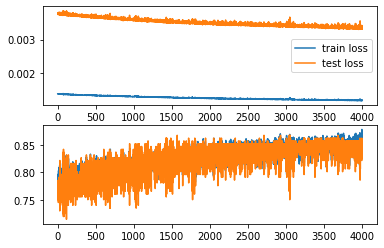

In [63]:
fig, ax = plt.subplots(2)
ax[0].plot(info['train_loss'], label='train loss')
ax[0].plot(info['test_loss'], label='test loss')

ax[0].legend()
ax[1].plot(info['train_acc'], label='Train')
ax[1].plot(info['test_acc'], label='Test')
plt.show()

Handle_vs_nonhandle

In [37]:
# train classifier
train_dataset = ToyGraspDataset(root='data', name='train_data', size=10000, is_pos_label=False, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='test_data', size=1000, is_pos_label=False, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [38]:
# first classifier balanced
f = ClassifierNN([2, 32, 1])
f = f.to(device)
optimizer = optim.Adam(f.parameters(), lr=0.001)

In [39]:
f, info = train_network(f, train_dataloader, train_dataset,
                                      test_dataloader, test_dataset,
                                      n_epochs=500, print_freq=40, optimizer=optimizer)
info['pos_samples_size'] = np.sum(train_dataset.data[:,2])
info['neg_samples_size'] = train_dataset.data.shape[0] - np.sum(train_dataset.data[:,2])
save_model_info(f, info, name='handle')

Epoch: 40
Train loss: 0.0019009318649768829 | Test losses: 0.0018942562639713287
Train acc: 0.8724 | Test acc: 0.859
Epoch: 80
Train loss: 0.0008005362361669541 | Test losses: 0.0007943392395973205
Train acc: 0.9462 | Test acc: 0.947
Epoch: 120
Train loss: 0.0005206408485770225 | Test losses: 0.0005065855830907822
Train acc: 0.9665 | Test acc: 0.969
Epoch: 160
Train loss: 0.0003882701635360718 | Test losses: 0.0003634224012494087
Train acc: 0.9744 | Test acc: 0.98
Epoch: 200
Train loss: 0.00030790767073631285 | Test losses: 0.00028360454365611076
Train acc: 0.9793 | Test acc: 0.981
Epoch: 240
Train loss: 0.0002555876395199448 | Test losses: 0.00023421303182840348
Train acc: 0.9816 | Test acc: 0.986
Epoch: 280
Train loss: 0.00023144843317568302 | Test losses: 0.00019843056797981263
Train acc: 0.9842 | Test acc: 0.99
Epoch: 320
Train loss: 0.00020053110979497432 | Test losses: 0.0001758558414876461
Train acc: 0.9873 | Test acc: 0.99
Epoch: 360
Train loss: 0.0001870648343116045 | Test los

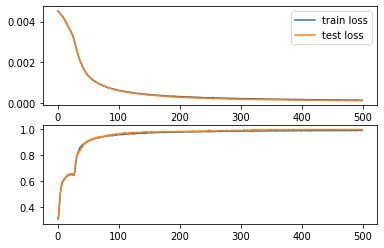

In [40]:
fig, ax = plt.subplots(2)
ax[0].plot(info['train_loss'], label='train loss')
ax[0].plot(info['test_loss'], label='test loss')

ax[0].legend()
ax[1].plot(info['train_acc'], label='Train')
ax[1].plot(info['test_acc'], label='Test')
plt.show()